In [28]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Projects/mwp_enhanced/modeling2
# Install and Load Libraries

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projects/mwp_enhanced/modeling2


# Install and Load Libraries

1.   List item
2.   List item



In [29]:
%%capture captured
!pip install yahoo-fin
!pip install hvplot
!pip install pandas-ta
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3
!pip install pycaret
!pip install "schemdraw<0.16"
!pip install mlflow --quiet
!pip install mplfinance
!pip install python-dotenv
# import modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import panel as pn
pn.extension('tabulator')
import pandas as pd

from panel.template import FastListTemplate
from pathlib import Path
from yahoo_fin.stock_info import get_data
import datetime
from matplotlib.figure import Figure
from matplotlib import cm
%matplotlib inline

# import modules that help build tabs
import modules.helpers as helpers
import modules.HistoricalData as hst
import modules.MCTab as MCTab
import modules.intro as intro
import modules.profile as prf
import modules.AlgoTab as at

import pandas_ta as ta
# import talib
# from yahoo_finance_api2 import share
import numpy as np
# import mplfinance as mpf

from joblib import dump, load
from pycaret.classification import *

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import mlflow
from getpass import getpass
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

from sklearn.metrics import brier_score_loss


load_dotenv()


# Load datasets

In [45]:
X_train = pd.read_csv(Path("./data/prepared/Xtrain.csv"))
X_test = pd.read_csv(Path("./data/prepared/Xtest.csv"))
y_train = pd.read_csv(Path("./data/prepared/ytrain.csv"))
y_test = pd.read_csv(Path("./data/prepared/ytest.csv"))
X_validation = pd.read_csv(Path("./data/prepared/Xvalidation.csv"))
y_validation = pd.read_csv(Path("./data/prepared/yvalidation.csv"))

In [46]:
# os.environ['MLFLOW_TRACKING_USERNAME'] = input('Enter your DAGsHub username: ')
# os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token: ')
# os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('Enter your DAGsHub project name: ')

In [47]:
mlflow.set_tracking_uri(f"https://dagshub.com/tlchampion/map_trials.mlflow")


# Run PyCaret comparisons to find potential models for training


## Round 1
Normalization only

In [48]:
round1 = ClassificationExperiment()
round1.setup(X_train ,
             target = y_train.squeeze(),
             session_id = 123, 
             fix_imbalance=False, 
             normalize=True, 
             normalize_method='minmax',
             use_gpu = False,
             log_experiment = True,
             experiment_name = "round1",
             log_plots = True)
round1.add_metric("brier", "Brier Score", brier_score_loss, greater_is_better = False, target="pred_proba")

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(64124, 33)"
4,Transformed data shape,"(64124, 33)"
5,Transformed train set shape,"(44886, 33)"
6,Transformed test set shape,"(19238, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


Name                                                       Brier Score
Display Name                                               Brier Score
Score Function           <function brier_score_loss at 0x7fc35fe9a950>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: brier, dtype: object

In [49]:
best1 = round1.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Brier Score,TT (Sec)
gbc,Gradient Boosting Classifier,0.5373,0.5420,0.8638,0.5420,0.6660,0.0278,0.0377,0.2461,0.2680
lightgbm,Light Gradient Boosting Machine,0.5353,0.5419,0.7521,0.5473,0.6335,0.0398,0.0438,0.2466,0.6060
lda,Linear Discriminant Analysis,0.5347,0.5259,0.9387,0.5369,0.6831,0.0105,0.0202,0.2485,0.3160
dummy,Dummy Classifier,0.5342,0.5000,1.0000,0.5342,0.6964,0.0000,0.0000,0.2488,0.4020
ridge,Ridge Classifier,0.5335,0.0000,0.9518,0.5356,0.6855,0.0058,0.0128,0.0000,0.1960
lr,Logistic Regression,0.5320,0.5254,0.9578,0.5346,0.6862,0.0016,0.0040,0.2485,0.7190
ada,Ada Boost Classifier,0.5294,0.5343,0.8027,0.5401,0.6457,0.0194,0.0231,0.2498,0.3050
xgboost,Extreme Gradient Boosting,0.5282,0.5347,0.6541,0.5491,0.5970,0.0384,0.0393,0.2546,0.2280
rf,Random Forest Classifier,0.5273,0.5358,0.6150,0.5516,0.5816,0.0420,0.0423,0.2516,1.5550
et,Extra Trees Classifier,0.5227,0.5327,0.6014,0.5486,0.5738,0.0340,0.0342,0.2534,2.8420


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [50]:

round1.save_model(best1,Path("./pycaret_models/model1"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['RSI_5', 'RSI_10', 'RSI_30',
                                              'RSI_60', '5day_avg_ret',
                                              '10day_avg_ret', '30day_avg_ret',
                                              '60day_avg_ret', 'macd2_chng',
                                              'macd5_chng', 'macd10_chng',
                                              'macd12_chng', 'ppo2', 'ppo2h',
                                              'ppo2s', 'ppo5', 'ppo5h', 'ppo5s',
                                              'ppo12', 'ppo12h', 'ppo12s',
                                              'ppo10',...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                         

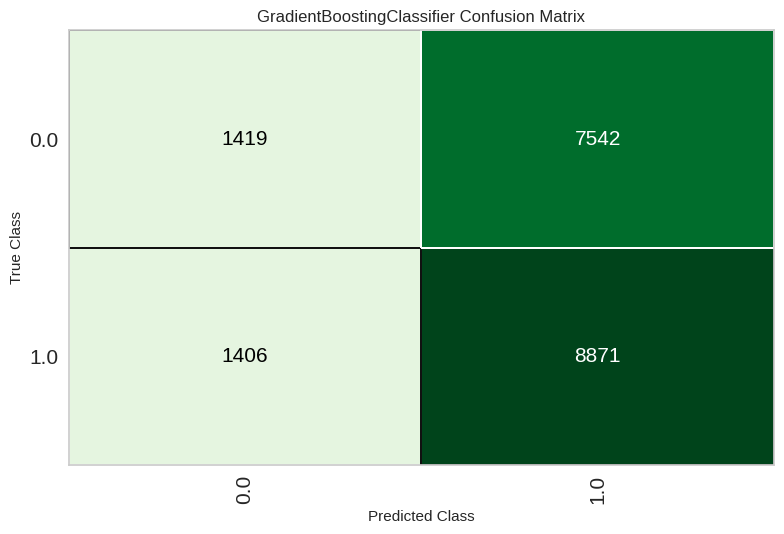

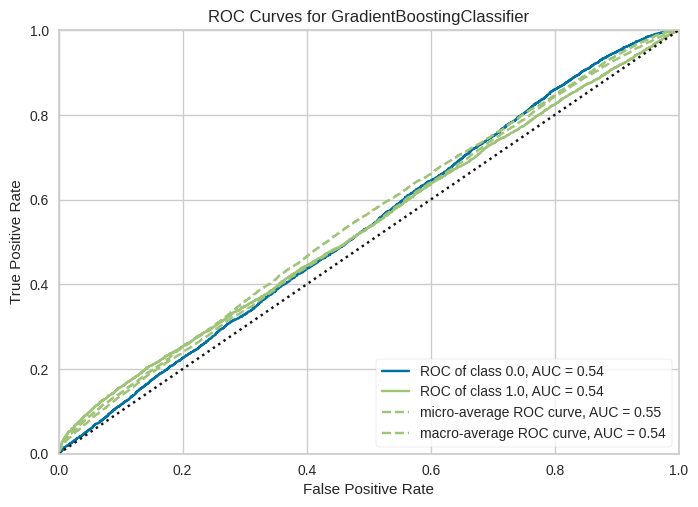

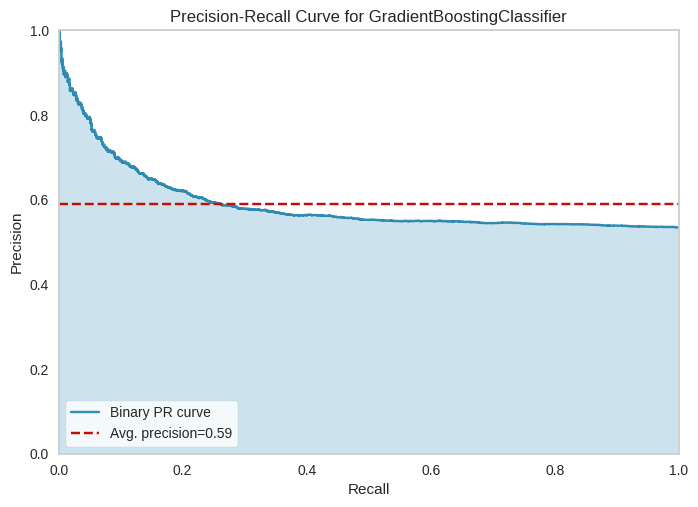

In [51]:
round1.plot_model(best1, plot='confusion_matrix')
print("")
round1.plot_model(best1, plot='auc')
print("")
round1.plot_model(best1, plot='pr')

## Round 2
Normalization and remove mulitcollinearality

In [52]:
round2 = ClassificationExperiment()
round2.setup(X_train  ,
             target = y_train.squeeze(), 
             session_id = 123, 
             fix_imbalance=False, 
             normalize=True, 
             normalize_method='minmax',
             use_gpu = False,
             remove_multicollinearity = True,
            log_experiment = True,
             experiment_name = "round2",
             log_plots = True)

round2.add_metric("brier", "Brier Score", brier_score_loss, greater_is_better = False, target="pred_proba")

best2 = round2.compare_models()

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(64124, 33)"
4,Transformed data shape,"(64124, 20)"
5,Transformed train set shape,"(44886, 20)"
6,Transformed test set shape,"(19238, 20)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Brier Score,TT (Sec)
gbc,Gradient Boosting Classifier,0.5375,0.5370,0.8677,0.5419,0.6671,0.0277,0.0377,0.2468,0.4240
lda,Linear Discriminant Analysis,0.5344,0.5235,0.9578,0.5359,0.6873,0.0070,0.0157,0.2486,0.3540
dummy,Dummy Classifier,0.5342,0.5000,1.0000,0.5342,0.6964,0.0000,0.0000,0.2488,0.2190
lr,Logistic Regression,0.5338,0.5222,0.9708,0.5351,0.6899,0.0036,0.0097,0.2485,0.2000
ridge,Ridge Classifier,0.5335,0.0000,0.9638,0.5352,0.6882,0.0040,0.0097,0.0000,0.1940
lightgbm,Light Gradient Boosting Machine,0.5313,0.5381,0.7514,0.5444,0.6314,0.0312,0.0344,0.2471,0.4770
ada,Ada Boost Classifier,0.5304,0.5333,0.8010,0.5408,0.6456,0.0217,0.0258,0.2498,0.3220
rf,Random Forest Classifier,0.5266,0.5344,0.6150,0.5510,0.5812,0.0405,0.0408,0.2523,1.6030
svm,SVM - Linear Kernel,0.5240,0.0000,0.8336,0.5366,0.6023,0.0025,0.0061,0.0000,0.1730
et,Extra Trees Classifier,0.5229,0.5318,0.6044,0.5486,0.5751,0.0341,0.0343,0.2538,2.7430


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [53]:
round2.save_model(best2,Path("./pycaret_models/model2"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['RSI_5', 'RSI_10', 'RSI_30',
                                              'RSI_60', '5day_avg_ret',
                                              '10day_avg_ret', '30day_avg_ret',
                                              '60day_avg_ret', 'macd2_chng',
                                              'macd5_chng', 'macd10_chng',
                                              'macd12_chng', 'ppo2', 'ppo2h',
                                              'ppo2s', 'ppo5', 'ppo5h', 'ppo5s',
                                              'ppo12', 'ppo12h', 'ppo12s',
                                              'ppo10',...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                         

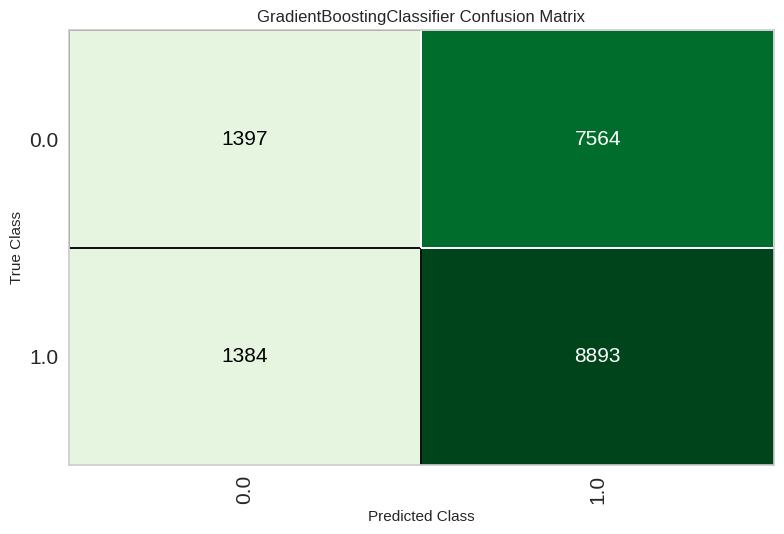

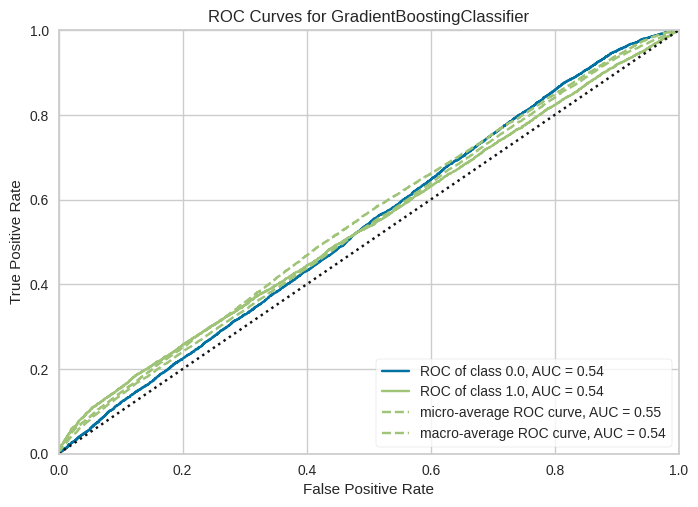

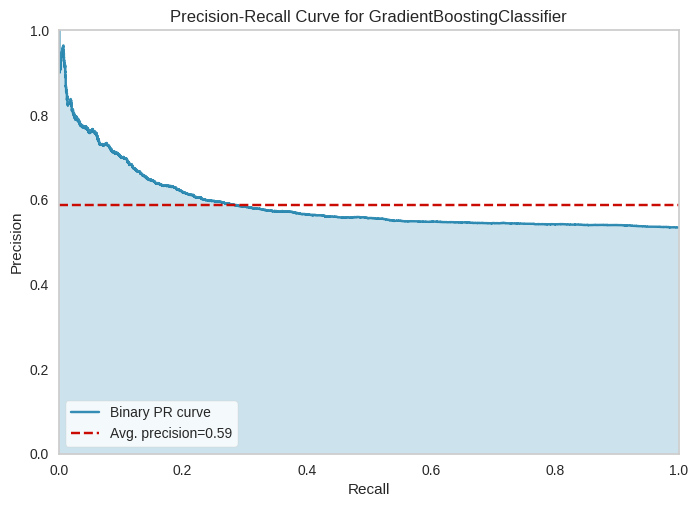

In [54]:
round2.plot_model(best2, plot='confusion_matrix')
print("")
round2.plot_model(best2, plot='auc')
print("")
round2.plot_model(best2, plot='pr')


## Round 3
Normalization and PCA

In [55]:
round3 = ClassificationExperiment()
round3.setup(X_train  ,
             target = y_train.squeeze(), 
             session_id = 123, 
             fix_imbalance=False, 
             normalize=True, 
             normalize_method='minmax',
             use_gpu = False,
             pca = True,
             pca_components = 0.75,
             log_experiment = True,
             experiment_name = "round3",
             log_plots = True)

round3.add_metric("brier", "Brier Score", brier_score_loss, greater_is_better = False, target="pred_proba")

best3 = round3.compare_models()

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(64124, 33)"
4,Transformed data shape,"(64124, 3)"
5,Transformed train set shape,"(44886, 3)"
6,Transformed test set shape,"(19238, 3)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Brier Score,TT (Sec)
svm,SVM - Linear Kernel,0.5342,0.0000,1.0000,0.5342,0.6964,0.0000,0.0000,0.0000,0.2420
dummy,Dummy Classifier,0.5342,0.5000,1.0000,0.5342,0.6964,0.0000,0.0000,0.2488,0.2090
lr,Logistic Regression,0.5341,0.5168,0.9980,0.5342,0.6959,0.0000,-0.0009,0.2487,0.2840
ridge,Ridge Classifier,0.5341,0.0000,0.9980,0.5342,0.6959,0.0000,-0.0009,0.0000,0.2080
lda,Linear Discriminant Analysis,0.5340,0.5168,0.9978,0.5342,0.6958,-0.0002,-0.0036,0.2487,0.2660
qda,Quadratic Discriminant Analysis,0.5335,0.5211,0.9533,0.5356,0.6859,0.0057,0.0125,0.2493,0.2410
ada,Ada Boost Classifier,0.5329,0.5261,0.8894,0.5380,0.6703,0.0141,0.0218,0.2499,1.9220
nb,Naive Bayes,0.5324,0.5187,0.9599,0.5348,0.6869,0.0022,0.0058,0.2490,0.3800
gbc,Gradient Boosting Classifier,0.5302,0.5260,0.9151,0.5353,0.6754,0.0041,0.0072,0.2480,5.3870
lightgbm,Light Gradient Boosting Machine,0.5280,0.5232,0.7817,0.5402,0.6389,0.0193,0.0223,0.2491,0.7250


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [56]:
round3.save_model(best3,Path("./pycaret_models/model3"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['RSI_5', 'RSI_10', 'RSI_30',
                                              'RSI_60', '5day_avg_ret',
                                              '10day_avg_ret', '30day_avg_ret',
                                              '60day_avg_ret', 'macd2_chng',
                                              'macd5_chng', 'macd10_chng',
                                              'macd12_chng', 'ppo2', 'ppo2h',
                                              'ppo2s', 'ppo5', 'ppo5h', 'ppo5s',
                                              'ppo12', 'ppo12h', 'ppo12s',
                                              'ppo10',...
                 ('trained_model',
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0

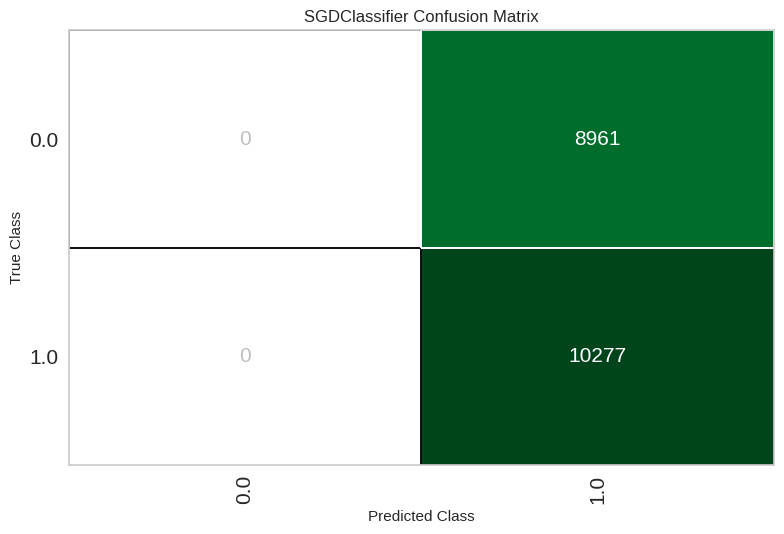

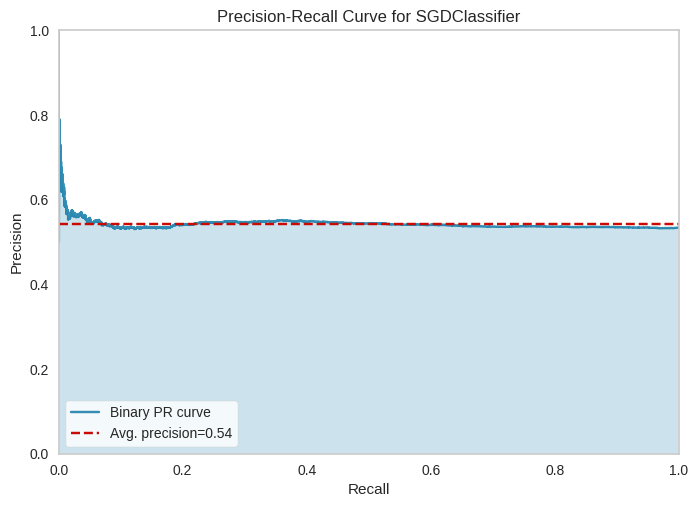

In [58]:
round3.plot_model(best3, plot='confusion_matrix')
print("")
# round3.plot_model(best3, plot='auc')
print("")
round3.plot_model(best3, plot='pr')

### Round 4
Normalize data
Feature Selection


In [60]:
round4 = ClassificationExperiment()
round4.setup(X_train  ,
             target = y_train.squeeze(), 
             session_id = 123, 
             fix_imbalance=False, 
             normalize=True, 
             normalize_method='minmax',
             use_gpu = False,
             log_experiment = True,
             experiment_name = "round3",
             log_plots = True,
             feature_selection = True,
             n_features_to_select = 0.25)

round4.add_metric("brier", "Brier Score", brier_score_loss, greater_is_better = False, target="pred_proba")

best4 = round4.compare_models()

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(64124, 33)"
4,Transformed data shape,"(64124, 9)"
5,Transformed train set shape,"(44886, 9)"
6,Transformed test set shape,"(19238, 9)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Brier Score,TT (Sec)
svm,SVM - Linear Kernel,0.5342,0.0000,1.0000,0.5342,0.6964,-0.0000,-0.0014,0.0000,0.3220
dummy,Dummy Classifier,0.5342,0.5000,1.0000,0.5342,0.6964,0.0000,0.0000,0.2488,0.2590
gbc,Gradient Boosting Classifier,0.5327,0.5366,0.8762,0.5385,0.6670,0.0156,0.0219,0.2467,13.9040
lda,Linear Discriminant Analysis,0.5325,0.5237,0.9578,0.5349,0.6864,0.0027,0.0068,0.2485,0.3370
ridge,Ridge Classifier,0.5322,0.0000,0.9599,0.5346,0.6867,0.0017,0.0043,0.0000,0.2440
ada,Ada Boost Classifier,0.5318,0.5350,0.8265,0.5404,0.6535,0.0211,0.0261,0.2498,3.4930
lightgbm,Light Gradient Boosting Machine,0.5317,0.5397,0.7540,0.5446,0.6324,0.0317,0.0350,0.2469,0.7770
lr,Logistic Regression,0.5316,0.5236,0.9637,0.5341,0.6873,-0.0004,-0.0007,0.2485,2.3480
xgboost,Extreme Gradient Boosting,0.5272,0.5309,0.6738,0.5467,0.6035,0.0335,0.0347,0.2526,8.6620
rf,Random Forest Classifier,0.5245,0.5344,0.6097,0.5496,0.5781,0.0368,0.0371,0.2525,19.4120


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [61]:
round4.save_model(best4,Path("./pycaret_models/model4"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['RSI_5', 'RSI_10', 'RSI_30',
                                              'RSI_60', '5day_avg_ret',
                                              '10day_avg_ret', '30day_avg_ret',
                                              '60day_avg_ret', 'macd2_chng',
                                              'macd5_chng', 'macd10_chng',
                                              'macd12_chng', 'ppo2', 'ppo2h',
                                              'ppo2s', 'ppo5', 'ppo5h', 'ppo5s',
                                              'ppo12', 'ppo12h', 'ppo12s',
                                              'ppo10',...
                 ('trained_model',
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0

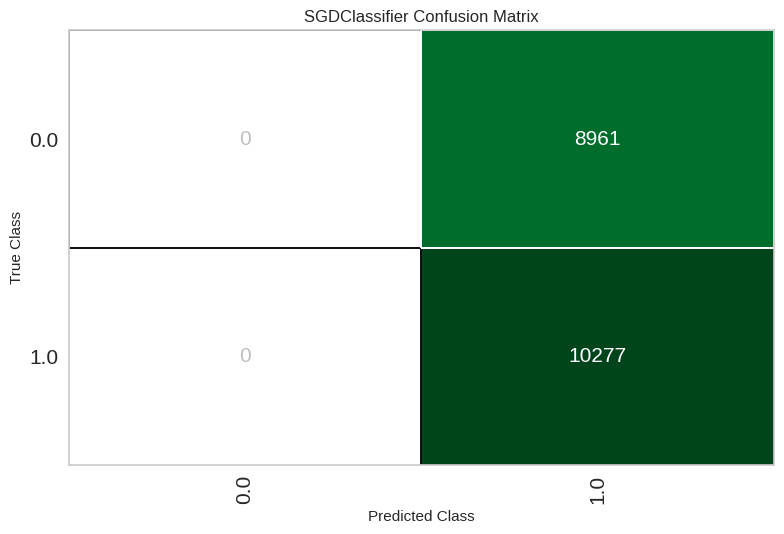

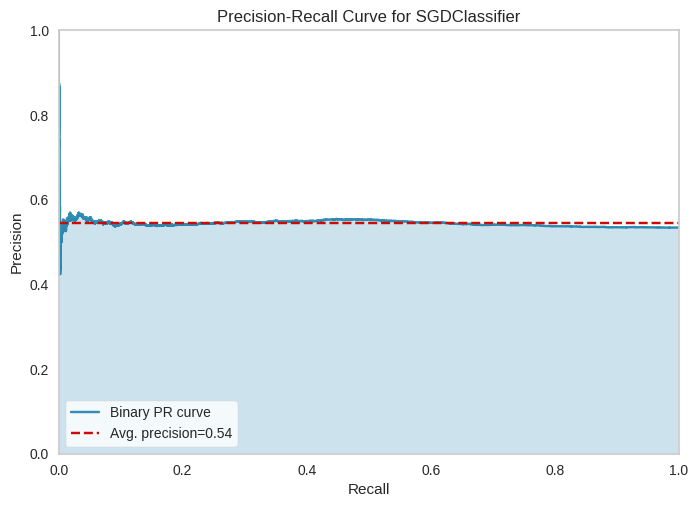

In [63]:
round4.plot_model(best4, plot='confusion_matrix')
print("")
# round4.plot_model(best4, plot='auc')
print("")
round4.plot_model(best4, plot='pr')

# Evaluate Initial Models

In [ ]:
# round1.evaluate_model(best1)

In [ ]:
# round2.evaluate_model(best2)

In [ ]:
# round3.evaluate_model(best3)

In [ ]:
# round4.evaluate_model(best4)